# Сопоставление фотографий керна

* [Задача](#Задача)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Валидация](#Валидация)

## Задача

Найти пары фотографий керна в дневном и ультрафиолетовом свете, которые не соответствуют друг другу (смещены, перевернуты, растянуты и пр.)

## Датасет

В датасет включены данные по трем скважинам. Каждая скважина представлена набором снимков керна в дневном и ультрафиолетовом свете, а также разметка пар снимков. Пары без дефектов отмечены 1, с дефектами - 0.

Пример хорошей пары:

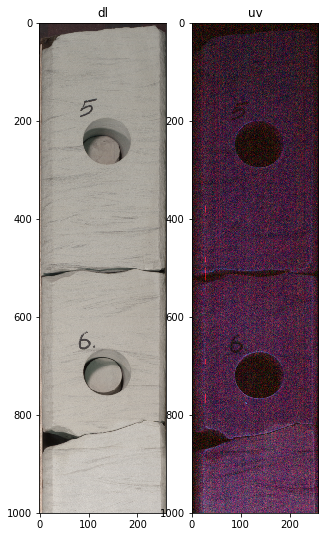

In [2]:
from utils import plot_pair, make_data, get_bounds, assemble, plot_predictions, plot_crops_predictions

plot_pair('/notebooks/data/processed_dataset/417', '417_2356.58_2357.56.png')

Пример плохой пары:

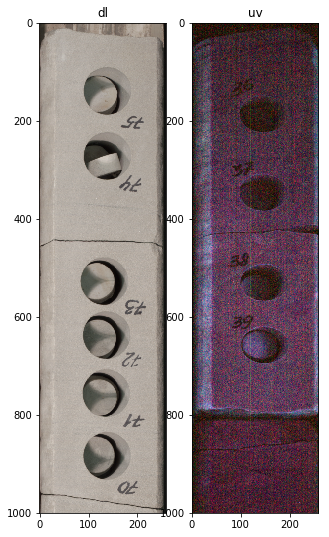

In [3]:
plot_pair('/notebooks/data/processed_dataset/417', '417_2360.6_2361.35.png')

Для решения задачи был написан `CoreBatch` с загрузчиком данных и необходимыми аугментациями.

In [4]:
import os
import sys
import glob

from PIL import Image

sys.path.insert(0, os.path.join("..", "..", ".."))

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from well_logs import CoreBatch
from well_logs.batchflow import Dataset, Pipeline, B, V, FilesIndex
from well_logs.batchflow.models.torch import ResNet18

In [5]:
PATH = '/notebooks/data/processed_dataset/*'

index = FilesIndex(path=os.path.join(PATH, 'samples_dl/*.png'))

## Предобработка данных

Загрузим файл с разметкой и обратим метки: теперь 1 соответствует плохой паре

In [6]:
df = pd.concat([pd.read_feather(filename) for filename in glob.glob(PATH+'/samples.feather')])
df['QC'] = 1 - df['QC']
df = df.set_index('SAMPLE')

Удалим из индекса все плохие пары, чтобы использовать только хорошие и их аугментированные варианты.

In [7]:
index = index.create_subset(np.intersect1d(df.index.values[df['QC'] == 0], index.indices))
ds = Dataset(index, CoreBatch)

Обучение будем производить на кропах следующего размера:

In [8]:
SHAPE = (2, 400, 150)

Чтобы избежать ошибок удалим из инднекса все пары изображений, у которых нне совпадают размеры:

In [9]:
shape_ppl = (ds.p
     .load()
     .check_shapes(dst='check')
     .init_variable('quality', init_on_each_run=list)
     .update_variable('quality', B('check'), mode='e')
     .init_variable('shape1', init_on_each_run=list)
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

shape_ppl.run()

Удалим маленькие изображения, из которых нельзя вырезать кроп заданного размера

In [10]:
short_ppl = (ds.p
     .load()
     .find_short_cores(SHAPE[1:], dst='short')
     .init_variable('short', init_on_each_run=list)
     .update_variable('short', B('short'), mode='e')
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

short_ppl.run()

filtered_index = ds.index.create_subset(
    ds.indices[np.logical_not(short_ppl.get_variable('short') or shape_ppl.get_variable('quality'))]
)

In [11]:
filtered_df = Dataset(filtered_index, CoreBatch)
filtered_df.split(shuffle=42)

In [12]:
len(filtered_df)

553

## Архитектура

Для предсказания будем использовать ResNet18 в базовом варианте

# Обучение

In [13]:
BATCH_SIZE = 64
N_EPOCH = 200

model_config = {'initial_block/inputs': 'images',
                'inputs/images/shape': SHAPE,
                'inputs/labels/classes': 2,
                'initial_block/inputs': 'images',
                'optimizer': 'Adam',
                'output': 'proba',
                'device': 'gpu:0',
                'loss': 'ce'}

При обучении будем использовать два типа аугментаций: отражение изображений по горизонтали и перемешивание фотографий, поскольку это два наиболее частых и плохих дефекта изображений. Также переведем изображения в ч/б.

In [14]:
bounds = get_bounds(PATH)

In [15]:
bounds

{'215': {'dl': 158.0, 'uv': 36.0},
 '3311': {'dl': 160.0, 'uv': 30.0},
 '417': {'dl': 176.0, 'uv': 20.0},
 '509': {'dl': 177.0, 'uv': 19.0},
 '604': {'dl': 191.0, 'uv': 48.0},
 '611': {'dl': 168.0, 'uv': 27.0}}

In [16]:
load_ppl = (Pipeline().load(grayscale=True).normalize(bounds=bounds))

with Pipeline() as p:
    augmentation_ppl = p.flip(proba=0.3) + p.shuffle(proba=0.3)

In [17]:
train_template = (Pipeline()
    .to_array(src='uv', dst='uv', channels='first')
    .to_array(src='dl', dst='dl', channels='first')
    .random_crop(shape=SHAPE[1:], proba=0)
     .init_model('dynamic', ResNet18, 'model', model_config)
     .init_variable('loss', init_on_each_run=list)
     .concatenate(dst='images')
     .train_model('model', B('images'), B('labels'), fetches='loss',
                 save_to=V('loss', mode='a'))
     .run(
        batch_size=BATCH_SIZE,
        n_epochs=N_EPOCH,
        shuffle=True,
        drop_last=True,
        lazy=True,
        bar=True
    )
)

In [18]:
train_ppl = (load_ppl + augmentation_ppl + train_template) << filtered_df.train

In [19]:
train_ppl.run()
train_ppl.get_model_by_name('model').save('resnet16.torch')

with open('loss', 'wb') as f:
    pickle.dump(train_ppl.get_variable('loss'), f)

with open('dataset', 'wb') as f:
    pickle.dump(filtered_df, f)

100%|██████████| 1200/1200 [33:00<00:00,  1.66s/it]


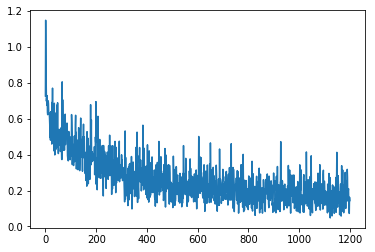

In [20]:
with open('loss', 'rb') as f:
    loss = pickle.load(f)
    
with open('dataset', 'rb') as f:
    filtered_df = pickle.load(f)

plt.plot(loss)
plt.show()

## Валидация

Сначала провалидируемся на кропах

In [21]:
test_template = (Pipeline()
     .to_array(src='uv', dst='uv', channels='first')
     .to_array(src='dl', dst='dl', channels='first')
     .random_crop(SHAPE[1:], proba=0)
     .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:1', 'load/path': 'resnet16.torch'
                })
     .init_variable('loss', init_on_each_run=list)
     .concatenate(dst='images')
     .init_variable('proba', init_on_each_run=None)
     .init_variable('metrics', init_on_each_run=None)
     .predict_model('model', B('images'), targets=B('labels'), fetches='proba', save_to=B('proba', mode='w'))
     .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                     fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
     .run(
        batch_size=BATCH_SIZE,
        n_epochs=10,
        shuffle=True,
        drop_last=False,
        lazy=True,
        bar=False
    )
)

In [22]:
test_ppl = (load_ppl + augmentation_ppl + test_template) << filtered_df.test

Посмотрим на примеры предсказаний

509_31.png
Label:  0.0   Prediction:0.001454862


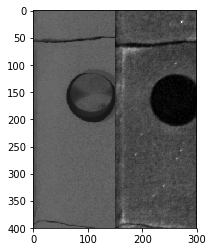

215_247.png
Label:  0.0   Prediction:0.8998339


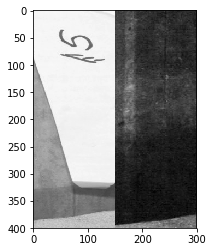

417_2511.29_2512.26.png
Label:  0.0   Prediction:0.0023273407


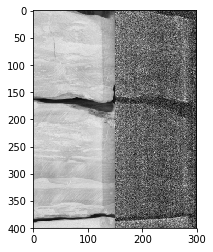

215_17.png
Label:  0.0   Prediction:0.0015014338


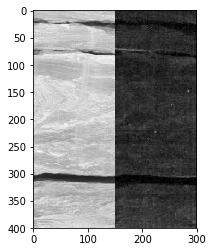

509_95.png
Label:  1.0   Prediction:0.80559576


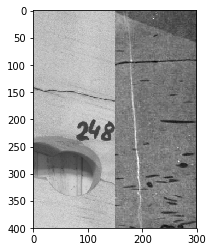

In [23]:
batch = test_ppl.next_batch()
plot_crops_predictions(batch)

In [24]:
test_ppl.reset_iter()
test_ppl.run()

metrics = test_ppl.get_variable('metrics')
print(metrics._confusion_matrix)

for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

[[[491  84]
  [ 18 517]]]
specificity : 0.9646365422396856
sensitivity : 0.8602329450915142
accuracy : 0.9081081081081082


# Провалидируемся на целых изображениях

In [25]:
test_template = (Pipeline()
    .to_array(src='uv', dst='uv', channels='first')
    .to_array(src='dl', dst='dl', channels='first')
    .crop(SHAPE[1:], 200, dst=('dl_crops', 'uv_crops', 'labels_crops'))
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:2', 'load/path': 'resnet16.torch'
                })
    .init_variable('loss', init_on_each_run=list)
    .call(make_data, save_to=(B('crops_conc'), B('labels_crops_conc')))
    .init_variable('proba', init_on_each_run=None)
    .init_variable('metrics', init_on_each_run=None)
    .predict_model('model', B('crops_conc'), targets=B('labels_crops_conc'), fetches='proba',
                   save_to=B('proba', mode='w'))
    .call(assemble, save_to=B('proba', mode='w'))
    .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                            fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
    .init_variable('stat', init_on_each_run=list)
    .update_variable('stat', (B('dl'), B('uv'), B('proba'), B('labels')), mode='a')
    .run(
        batch_size=8,
        n_epochs=1,
        shuffle=False,
        drop_last=False,
        lazy=True,
        bar=False
    )
)

In [26]:
test_ppl = (load_ppl + augmentation_ppl + test_template) << filtered_df.test

In [27]:
test_ppl.reset_iter()
test_ppl.run()

In [28]:
metrics = test_ppl.get_variable('metrics')
metrics._confusion_matrix

array([[[39,  1],
        [ 3, 68]]])

In [29]:
for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

specificity : 0.9285714285714286
sensitivity : 0.9855072463768116
accuracy : 0.963963963963964


Посмотрим на ошибки, которые допускает модель.

## False negative

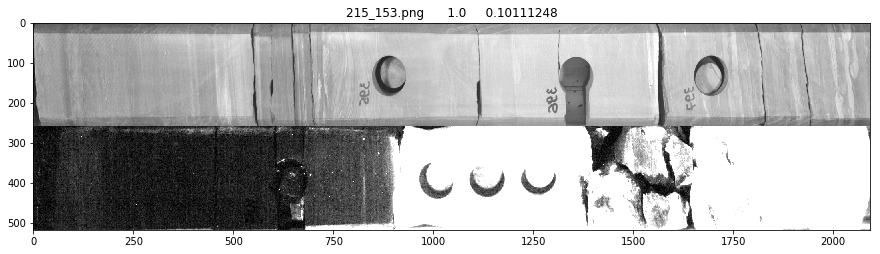

In [30]:
plot_predictions(test_ppl, 'fn')

## False positive

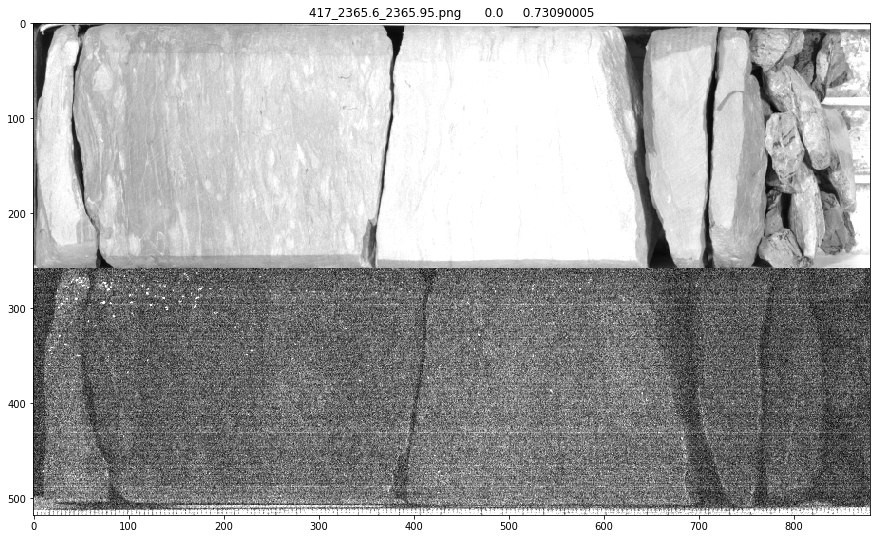

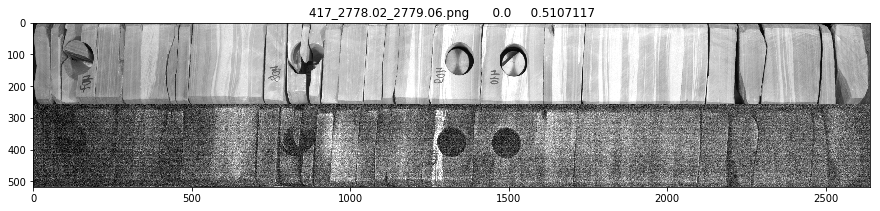

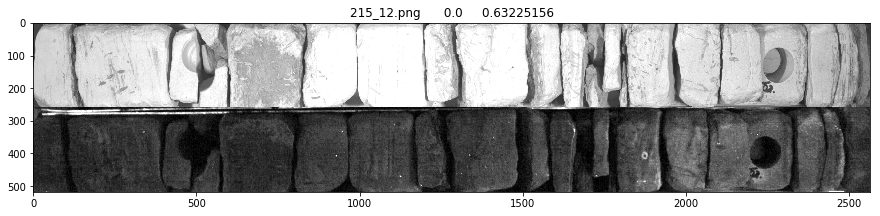

In [31]:
plot_predictions(test_ppl, 'fp')